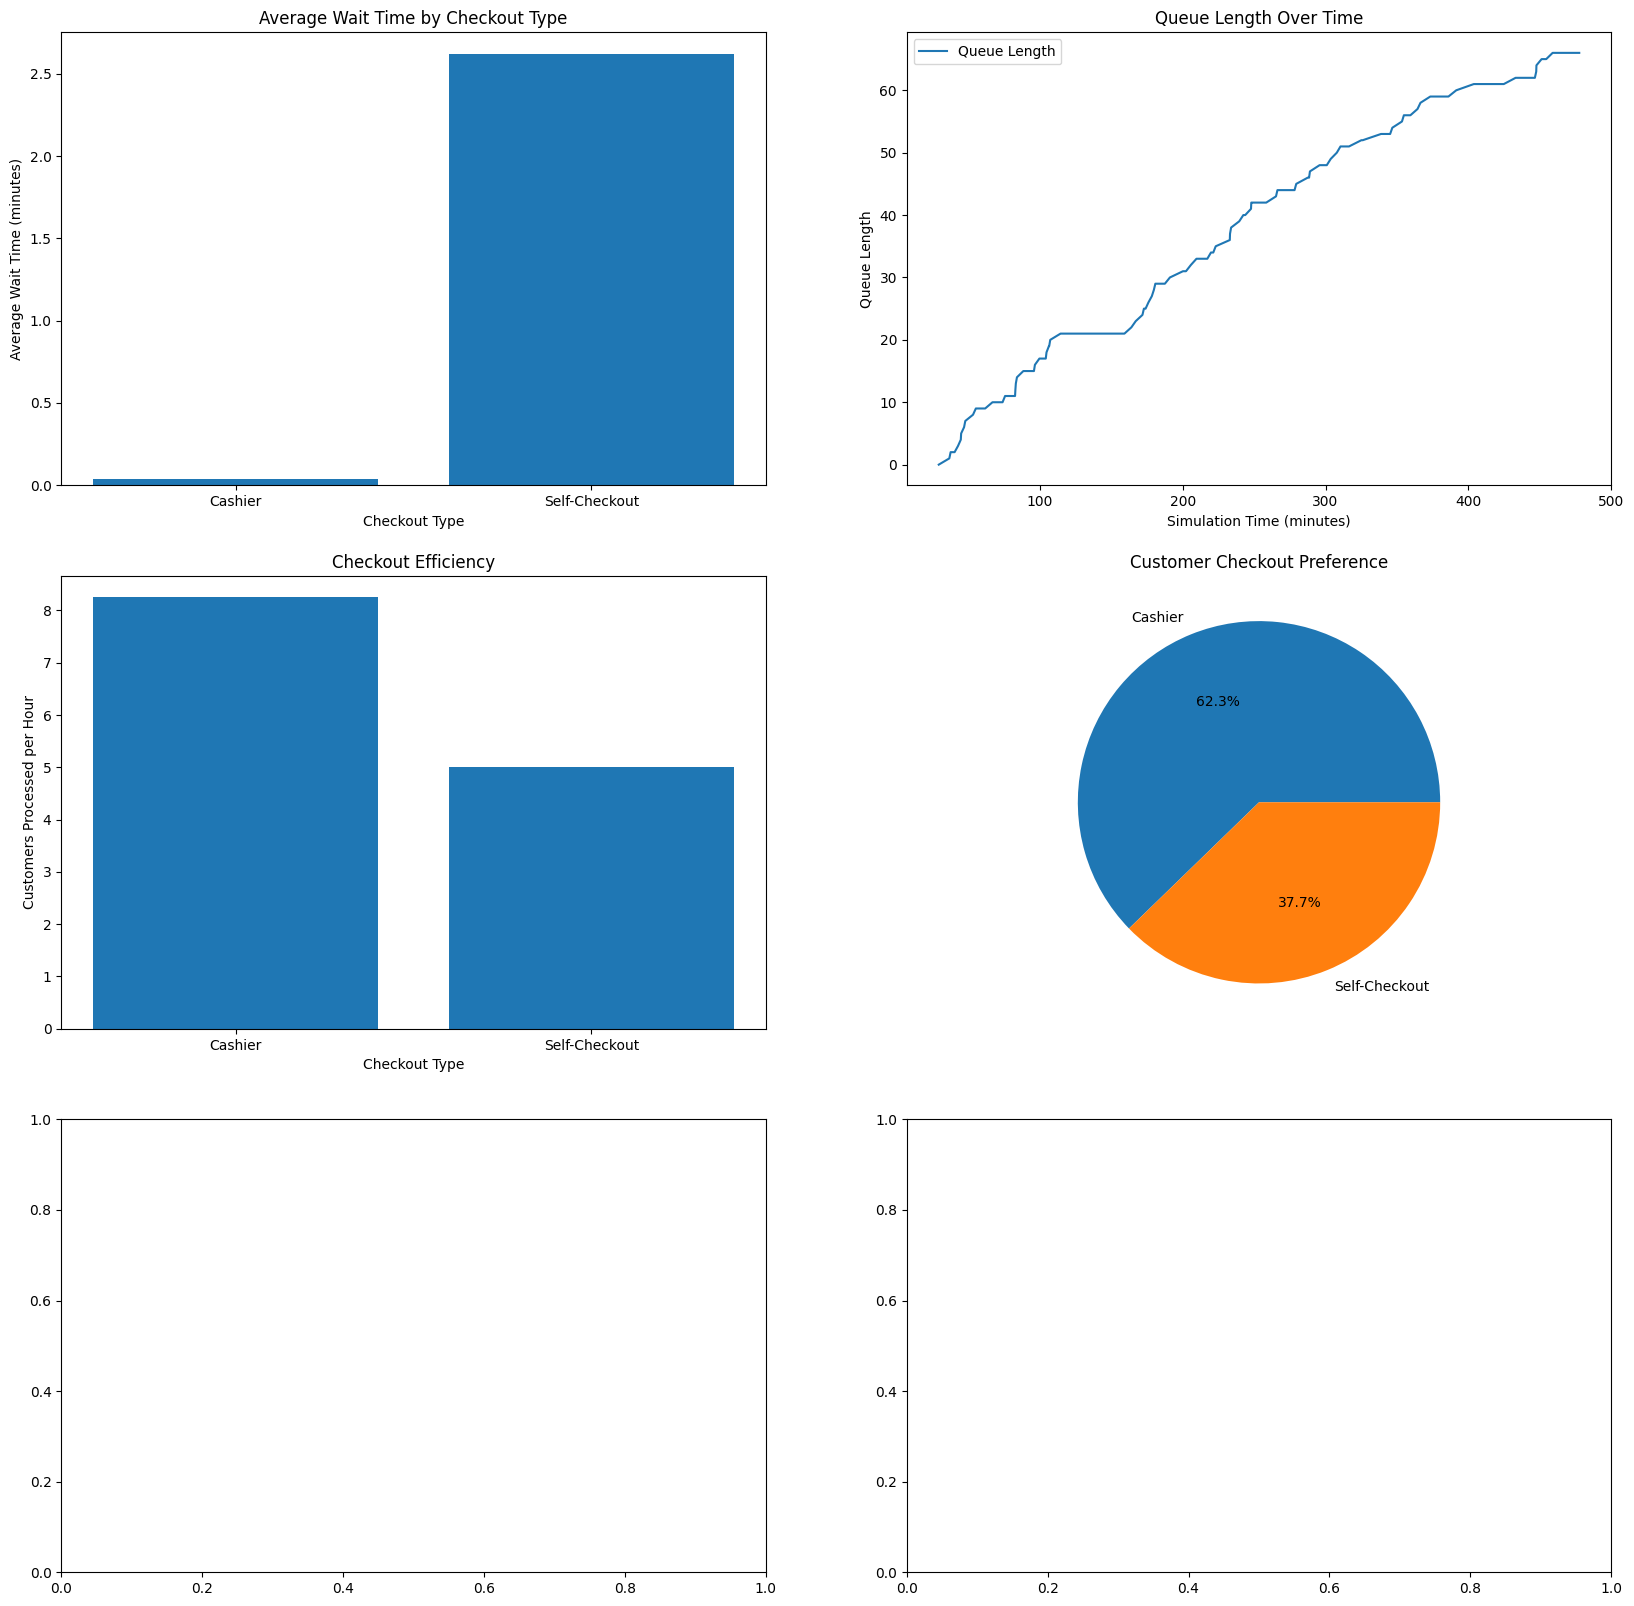

<Figure size 640x480 with 0 Axes>

,Timestamp,ShoppingTime,CheckoutQueueTime,ServiceTime,CheckoutType
0,29.22,17.52,0.00,6.60,Self-Checkout
1,36.61,20.05,0.00,4.21,Cashier
2,37.53,18.46,0.00,3.10,Cashier
3,40.31,19.31,0.00,9.10,Self-Checkout
4,42.71,22.83,0.00,6.30,Cashier
5,44.65,24.02,0.00,5.94,Cashier
6,44.90,34.06,0.00,5.62,Cashier
7,46.94,24.25,0.00,4.14,Cashier
8,47.80,28.69,0.02,3.15,Cashier
9,53.20,27.52,0.00,7.63,Cashier


In [1]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

class GroceryStore:
    def __init__(self, env, num_cashiers, num_self_checkouts, arrival_rate, shopping_time_mean, shopping_time_std, cashier_service_time_mean, cashier_service_time_std, self_checkout_service_time_mean, self_checkout_service_time_std, seed):
        self.env = env
        self.cashier_queue = simpy.Resource(env, num_cashiers if num_cashiers > 0 else float('inf'))
        self.self_checkout_queue = simpy.Resource(env, num_self_checkouts)
        self.arrival_rate = arrival_rate
        self.shopping_time_mean = shopping_time_mean
        self.shopping_time_std = shopping_time_std
        self.cashier_service_time_mean = cashier_service_time_mean
        self.cashier_service_time_std = cashier_service_time_std
        self.self_checkout_service_time_mean = self_checkout_service_time_mean
        self.self_checkout_service_time_std = self_checkout_service_time_std
        self.seed = seed
        self.data = []

        # Set the seed for reproducibility
        random.seed(self.seed)
        np.random.seed(self.seed)

    def customer_arrival(self):
        while True:
            # Generate customer arrivals using a Poisson distribution
            interarrival_time = random.expovariate(self.arrival_rate)
            yield self.env.timeout(interarrival_time)
            self.env.process(self.customer_flow())

    def customer_flow(self):
        # Simulate shopping time using a normal distribution
        shopping_time = random.normalvariate(self.shopping_time_mean, self.shopping_time_std)
        yield self.env.timeout(max(0, shopping_time))
    
        # Decide whether the customer chooses cashier or self-checkout
        if len(self.cashier_queue.queue) < len(self.self_checkout_queue.queue) or self.self_checkout_queue.capacity == 0:
            checkout_type = 'Cashier'
            queue = self.cashier_queue
            service_time_mean = self.cashier_service_time_mean
            service_time_std = self.cashier_service_time_std
        else:  # If both queues are the same length, choose randomly
            if random.random() < 0.5 or self.self_checkout_queue.capacity == 0:
                checkout_type = 'Cashier'
                queue = self.cashier_queue
                service_time_mean = self.cashier_service_time_mean
                service_time_std = self.cashier_service_time_std
            else:
                checkout_type = 'Self-Checkout'
                queue = self.self_checkout_queue
                service_time_mean = self.self_checkout_service_time_mean
                service_time_std = self.self_checkout_service_time_std
    
        checkout_start = self.env.now
        with queue.request() as request:
            yield request
            checkout_queue_time = self.env.now - checkout_start
            service_time = random.normalvariate(service_time_mean, service_time_std)
            service_time = max(0, service_time)  # Ensure service time is non-negative
            yield self.env.timeout(service_time)
            self.data.append([self.env.now, shopping_time, checkout_queue_time, service_time, checkout_type])

def run_simulation(simulation_time, num_cashiers, num_self_checkouts, arrival_rate, shopping_time_mean, shopping_time_std, cashier_service_time_mean, cashier_service_time_std, self_checkout_service_time_mean, self_checkout_service_time_std, seed):
    env = simpy.Environment()
    grocery_store = GroceryStore(env, num_cashiers, num_self_checkouts, arrival_rate, shopping_time_mean, shopping_time_std, cashier_service_time_mean, cashier_service_time_std, self_checkout_service_time_mean, self_checkout_service_time_std, seed)
    env.process(grocery_store.customer_arrival())
    env.run(until=simulation_time)

    # Convert collected data to a DataFrame
    df = pd.DataFrame(grocery_store.data, columns=['Timestamp', 'ShoppingTime', 'CheckoutQueueTime', 'ServiceTime', 'CheckoutType'])
    return df

# Example usage
simulation_time = 8 * 60  # Simulate 8 hours (in minutes)
num_cashiers = 3
num_self_checkouts = 1

# If num_self_checkouts is 0, set it to a large number to simulate an "infinite" queue
num_self_checkouts = num_self_checkouts if num_self_checkouts > 0 else float('inf')
arrival_rate = 1/5  # Average 5 customers per hour
shopping_time_mean = 20
shopping_time_std = 5
cashier_service_time_mean = 5
cashier_service_time_std = 2
self_checkout_service_time_mean = 8
self_checkout_service_time_std = 3
seed = 42  # Set a seed value for reproducibility

simulation_data = run_simulation(simulation_time, num_cashiers, num_self_checkouts, arrival_rate, shopping_time_mean, shopping_time_std, cashier_service_time_mean, cashier_service_time_std, self_checkout_service_time_mean, self_checkout_service_time_std, seed)

# Round the simulation data to 2 decimal places
simulation_data = simulation_data.round(2)

# Set up a grid of plots
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# Graph 1: Average Wait Time
cashier_wait_time = simulation_data[simulation_data['CheckoutType'] == 'Cashier']['CheckoutQueueTime'].mean()
self_checkout_wait_time = simulation_data[simulation_data['CheckoutType'] == 'Self-Checkout']['CheckoutQueueTime'].mean()
axs[0, 0].bar(['Cashier', 'Self-Checkout'], [cashier_wait_time, self_checkout_wait_time])
axs[0, 0].set_xlabel('Checkout Type')
axs[0, 0].set_ylabel('Average Wait Time (minutes)')
axs[0, 0].set_title('Average Wait Time by Checkout Type')

# Graph 2: Queue Length
cashier_queue_length = simulation_data[simulation_data['CheckoutType'] == 'Cashier'].shape[0]
self_checkout_queue_length = simulation_data[simulation_data['CheckoutType'] == 'Self-Checkout'].shape[0]
axs[0, 1].plot(simulation_data['Timestamp'], simulation_data['CheckoutType'].map({'Cashier': 1, 'Self-Checkout': 0}).cumsum(), label='Queue Length')
axs[0, 1].set_xlabel('Simulation Time (minutes)')
axs[0, 1].set_ylabel('Queue Length')
axs[0, 1].set_title('Queue Length Over Time')
axs[0, 1].legend()

# Graph 3: Checkout Efficiency
cashier_efficiency = cashier_queue_length / (simulation_time / 60)
self_checkout_efficiency = self_checkout_queue_length / (simulation_time / 60) if num_self_checkouts > 0 else 0
axs[1, 0].bar(['Cashier', 'Self-Checkout'], [cashier_efficiency, self_checkout_efficiency])
axs[1, 0].set_xlabel('Checkout Type')
axs[1, 0].set_ylabel('Customers Processed per Hour')
axs[1, 0].set_title('Checkout Efficiency')

# Graph 4: Customer Experience
checkout_preference = simulation_data['CheckoutType'].value_counts(normalize=True)
axs[1, 1].pie(checkout_preference, labels=checkout_preference.index, autopct='%1.1f%%')
axs[1, 1].set_title('Customer Checkout Preference')

# Graph 5: Resource Utilization
cashier_utilization = simulation_data[simulation_data['CheckoutType'] == 'Cashier']['ServiceTime'].sum() / (num_cashiers * simulation_time)
self_checkout_utilization = simulation_data[simulation_data['CheckoutType'] == 'Self-Checkout']['ServiceTime'].sum() / (num_self_checkouts * simulation_time)
axs[2, 0].bar(['Cashier', 'Self-Checkout'], [cashier_utilization, self_checkout_utilization])
axs[2, 0].set_xlabel('Checkout Type')
axs[2, 0].set_ylabel('Utilization')
axs[2, 0].set_title('Resource Utilization')

# Graph 6: Sensitivity Analysis
arrival_rates = [1/10, 1/8, 1/6, 1/4]
avg_wait_times = []
for rate in arrival_rates:
    simulation_data_sensitivity = run_simulation(simulation_time, num_cashiers, num_self_checkouts, rate, shopping_time_mean, shopping_time_std, cashier_service_time_mean, cashier_service_time_std, self_checkout_service_time_mean, self_checkout_service_time_std, seed)
    avg_wait_time = simulation_data_sensitivity['CheckoutQueueTime'].mean()
    avg_wait_times.append(avg_wait_time)
axs[2, 1].plot(arrival_rates, avg_wait_times, marker='o')
axs[2, 1].set_xlabel('Customer Arrival Rate (customers per minute)')
axs[2, 1].set_ylabel('Average Wait Time (minutes)')
axs[2, 1].set_title('Sensitivity Analysis - Arrival Rate vs. Wait Time')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()
# Python
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns

# Python
simulation_data.reset_index(drop=True, inplace=True)

display(simulation_data)

In [ ]:
# Python
checkout_preference = simulation_data['CheckoutType'].value_counts(normalize=True)
axs[1, 1].pie(checkout_preference, labels=checkout_preference.index, autopct='%1.1f%%')
axs[1, 1].set_title('Customer Checkout Preference')

# Add a border around the graph
for spine in axs[1, 1].spines.values():
    spine.set_edgecolor('black')

plt.show()

In [ ]:
# Python
checkout_preference = simulation_data['CheckoutType'].value_counts(normalize=True)
axs[1, 1].pie(checkout_preference, labels=checkout_preference.index, autopct='%1.1f%%')
axs[1, 1].set_title('Customer Checkout Preference')

# Add a border around the graph
for spine in axs[1, 1].spines.values():
    spine.set_edgecolor('black')

plt.show()